<a href="https://colab.research.google.com/github/bchoi2004/Advection-Equation-/blob/main/1D_Advection_Equation_Solver_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D Advection Equation Solver Using Deep Learning

## Introduction and Problem Description
The 1D Advection Equation is a fundamental equation in fluid dynamics and atmospheric sciences, representing the transport of a quantity (like pollutant concentration, heat, etc.) in a flow field. The equation is written as:

$$
\boxed{∂φ/∂t + u.∂φ/∂x = 0}
$$

where $φ$ is the quantity being advected, $u$ is the advection velocity, $x$ is the spatial coordinate, and $t$ is time.

### Advection Problem Case
In this specific case, we consider the following initial and boundary conditions:

- **Initial condition:** $φ(x,0) = \exp(-200(x-0.25)^2 )$
- **Periodic boundary condition:** $φ(0,t) = φ(L,t)$  
- **Wave speed:** $u = 1$
- **Spatial domain:** $x ∈ [0, L],  \;L = 1$
- **Time domain:** $t ∈ [0,1]$

The analytical solution of this problem is given by:

  $$
\boxed{φ(x,t) = \exp\left(-200 \left(x - 0.25 - ut\right)^2\right)}
$$

## Deep Learning Approach for Solving 1D Advection PDE
Deep learning, particularly neural networks, has shown promising results in approximating solutions to differential equations. The flexibility and adaptability of neural networks make them suitable for complex problems where traditional methods might be challenging to apply.

### Neural Network Model Architecture
The architecture of the neural network used in this problem includes multiple layers with different activation functions. The model aims to learn the mapping of $(x, t)$ pairs to the solution $φ$.

## Implementation in Python
The following Python codes sets up the neural network, defines the problem specifics, and trains the model to solve the 1D Advection Equation.
<br>
<br><br>




## Import the required libraries and mount drive

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
my_dir = '/content/gdrive/My Drive/Spring_2024_DL/'

### Setup the problem and grid parameters

In [ ]:
# Set random seed for reproducibility
np.random.seed(4155)
tf.random.set_seed(4155)

# Advection velocity
u = 1

# Generate meshgrid for the input data
Nx, Nt = 100, 100
xlim, tlim = 1,1

x_np = np.linspace(0, xlim, Nx)
t_np = np.linspace(0, tlim, Nt)

dx = xlim/(Nx-1)
dt = tlim/(Nt-1)

X, T = np.meshgrid(x_np, t_np)
data = np.c_[X.ravel(), T.ravel()]

### Setup DNN architecture

In [ ]:
# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(110, activation='swish', input_shape=(2,)),
    tf.keras.layers.Dense(55, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Define the Inital condition and Loss Function

In [ ]:
# Initial condition
def phi_inital(x):
    return tf.exp(-200 * ((x - 0.25) ** 2))

# Custom loss function for PDE
def custom_loss(x, t):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])  #For non-trainable variables

        # Prediction across domain
        phi_pred = model(tf.concat([x, t], axis=1), training=True)
        phi_pred_dx = tape.gradient(phi_pred, x)
        phi_pred_dt = tape.gradient(phi_pred, t)

        # Prediction at inital condition
        phi_pred_t0 = model(tf.concat([x, tf.zeros_like(t)], axis=1), training=True)

        # Prediction at boundary condition
        phi_pred_x0 = model(tf.concat([tf.zeros_like(x), t], axis=1), training=True)
        phi_pred_x1 = model(tf.concat([tf.ones_like(x), t], axis=1), training=True)


    loss_pde = tf.reduce_mean(tf.square(phi_pred_dx + u*phi_pred_dt))
    loss_initial = tf.reduce_mean(tf.square(phi_pred_t0 - phi_inital(x)))
    loss_bc_period = tf.reduce_mean(tf.square(phi_pred_x0 - phi_pred_x1))

    total_loss = 50*loss_pde + 200*loss_initial + loss_bc_period

    return total_loss

### Model training parameters

In [ ]:
# Training configuration
optimizer = tf.optimizers.Adam(learning_rate=0.0085)    #0.0075
epochs = 200
batch_size = 512

### Training Loop and saving model

In [ ]:
# Training loop
epochs = 200
batch_size = 512

for epoch in range(epochs):

    data_ = np.random.permutation(data)
    total_loss = 0
    num_batches = 0

    for i in range(0, data_.shape[0], batch_size):
        batch = data_[i:i + batch_size]
        x_batch, t_batch = [tf.convert_to_tensor(batch[:, j:j+1], dtype=tf.float32) for j in range(2)]

        with tf.GradientTape() as tape:
            loss = custom_loss(x_batch, t_batch)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_loss += loss.numpy()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss}')


# Save the model
model.save(my_dir+'dnn_solver_1d_advection2.h5')

Epoch 1, Average Loss: 24.30442695617676
Epoch 2, Average Loss: 15.74532217979431
Epoch 3, Average Loss: 13.817210388183593
Epoch 4, Average Loss: 13.06468448638916
Epoch 5, Average Loss: 12.900218963623047
Epoch 6, Average Loss: 12.837419557571412
Epoch 7, Average Loss: 12.818920803070068
Epoch 8, Average Loss: 12.730705833435058
Epoch 9, Average Loss: 12.607112407684326
Epoch 10, Average Loss: 12.251157188415528
Epoch 11, Average Loss: 11.639121770858765
Epoch 12, Average Loss: 10.198354864120484
Epoch 13, Average Loss: 7.598657035827637
Epoch 14, Average Loss: 4.523382401466369
Epoch 15, Average Loss: 2.350005203485489
Epoch 16, Average Loss: 1.284559515118599
Epoch 17, Average Loss: 0.8049412906169892
Epoch 18, Average Loss: 0.5765183627605438
Epoch 19, Average Loss: 0.4493443325161934
Epoch 20, Average Loss: 0.3697396382689476
Epoch 21, Average Loss: 0.3190293848514557
Epoch 22, Average Loss: 0.28028115183115004
Epoch 23, Average Loss: 0.25422162339091303
Epoch 24, Average Loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200, Average Loss: 0.08729961253702641


### Load Trained Model

In [ ]:
# Load the model for test evaluation
loaded_model = tf.keras.models.load_model(my_dir+'dnn_solver_1d_advection.h5', compile=False)

### Define Analytical Solution

In [ ]:
def phi_analytical(x,t):
    return np.exp(-200*((x-0.25-u*t)**2))

### Model Prediction and Performance Analysis

In [ ]:
# Prediction and analysis
points_tf = tf.convert_to_tensor(data, dtype=tf.float32)
phi_dnn = loaded_model(points_tf).numpy().flatten()

phi_true = phi_analytical(X.ravel(), T.ravel()).flatten()
diff = np.abs(phi_true - phi_dnn)
mse_dnn = np.mean(diff**2)

print(f'\nMax Absolute Error = {np.max(diff):.3f}')
print("Mean Squared Error = ", mse_dnn)


Max Absolute Error = 0.029
Mean Squared Error =  4.911933540722889e-05


### Reshaping for grid visualization

In [ ]:
phi_analytic_grid = phi_true.reshape((Nt,Nx))
phi_dnn_grid = phi_dnn.reshape((Nt,Nx))
phi_error_grid = (phi_dnn_grid - phi_analytic_grid)

### Contour plot of Analytical solution

<ipython-input-17-b96864697894>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


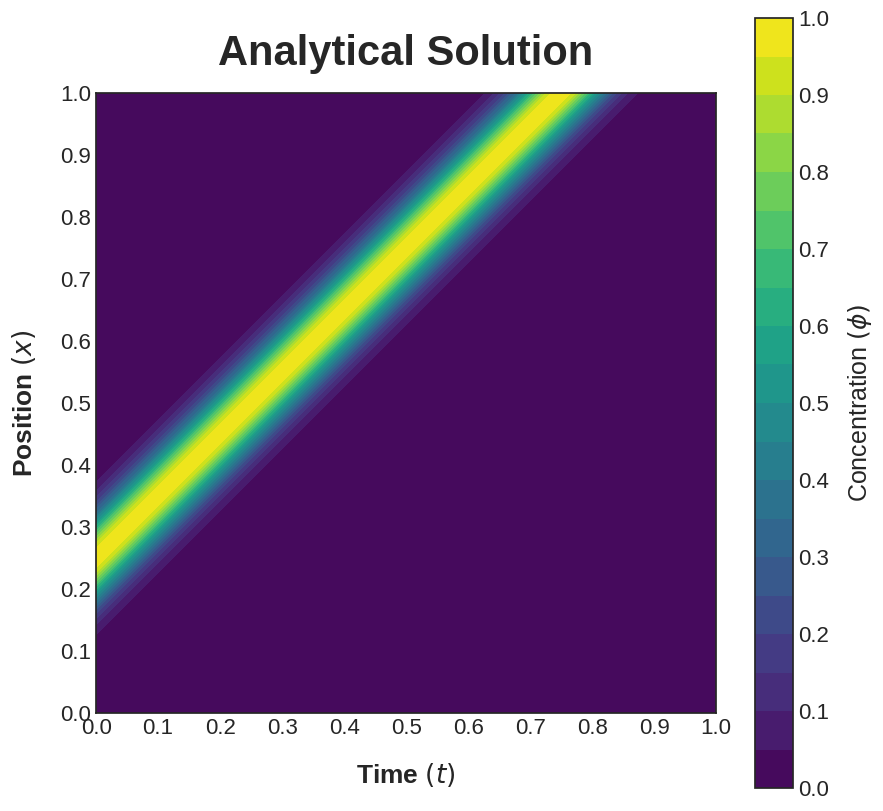

In [ ]:
cmap = plt.cm.viridis  #gist_earth
plt.style.use('seaborn-white')

fig1,ax = plt.subplots(figsize=(10,10))
ax.set_title('Analytical Solution', fontsize=30,fontweight='bold',pad=20)

levels = np.linspace(0,1,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, phi_analytic_grid, cmap=cmap, levels=levels)

tick_values = np.arange(0, 1+0.0001, 0.1)
cbar = fig1.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Concentration $(\phi)$', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,tlim+0.0001,0.1))
ax.set_yticks(np.arange(0,xlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'analytical_solution.png', format='png', dpi = 300)
# plt.close()

### Contour plot of DNN solution

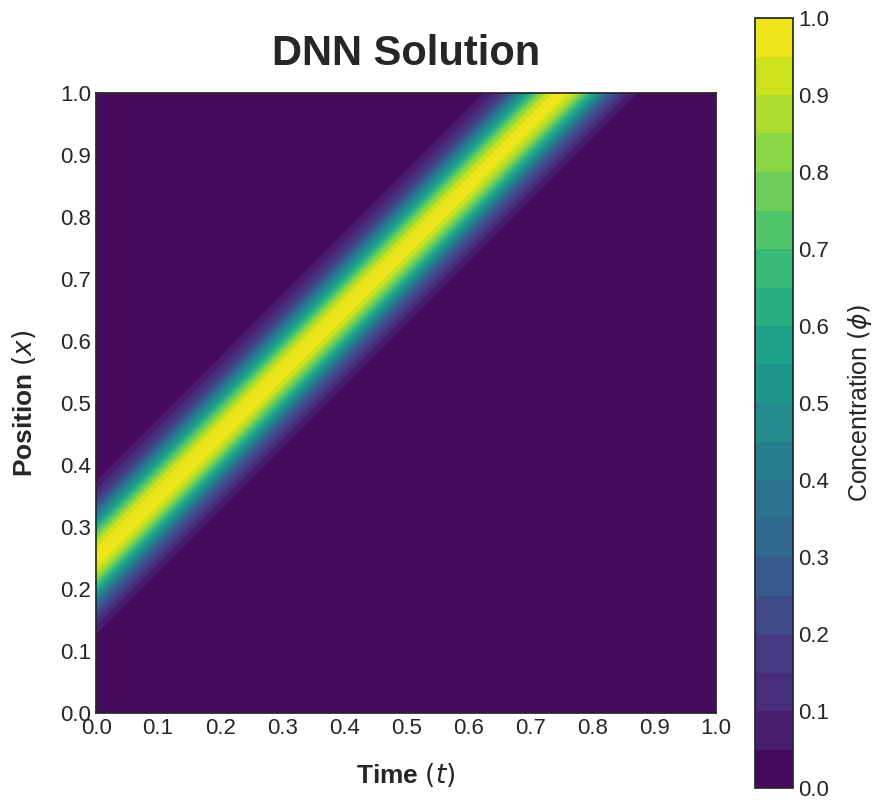

In [ ]:
fig2,ax = plt.subplots(figsize=(10,10))
ax.set_title('DNN Solution', fontsize=30,fontweight='bold',pad=20)
cmap = plt.cm.viridis

levels = np.linspace(0,1,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, phi_dnn_grid, cmap=cmap, levels=levels)

tick_values = np.arange(0, 1+0.0001, 0.1)
cbar = fig2.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Concentration $(\phi)$', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,tlim+0.0001,0.1))
ax.set_yticks(np.arange(0,xlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'dnn_solution.png', format='png', dpi = 300)
# plt.close()

### Error in Solution

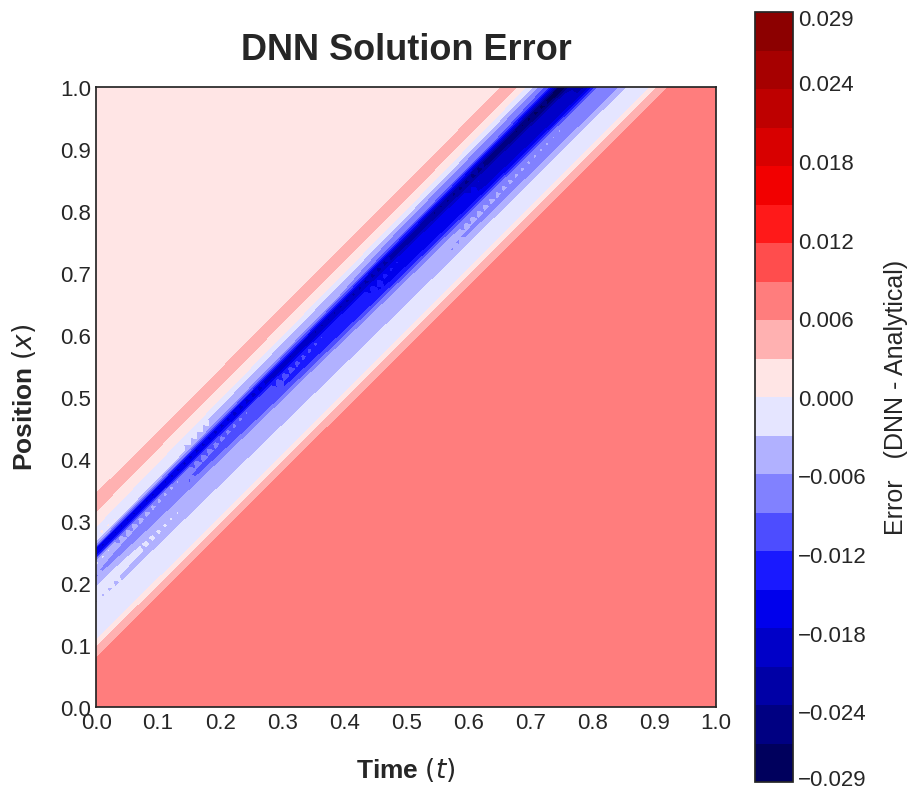

In [ ]:
fig3,ax = plt.subplots(figsize=(10,10))
ax.set_title('DNN Solution Error',fontsize=26,fontweight='bold',pad=20)
cmap = plt.cm.seismic

error_lim = np.max([abs(phi_error_grid.min()), abs(phi_error_grid.max())])

levels = np.linspace(-error_lim,error_lim,20+1)

ax.set_aspect('equal')
cf = ax.contourf(T, X, phi_error_grid, cmap=cmap, levels=levels)

tick_values = np.around(np.linspace(-error_lim, error_lim, 10+1), decimals=3)
cbar = fig3.colorbar(cf, ax=ax, pad=0.05, ticks=tick_values)
cbar.set_label(r'Error   (DNN - Analytical)', labelpad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks(np.arange(0,tlim+0.0001,0.1))
ax.set_yticks(np.arange(0,xlim+0.0001,0.1))
ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_xlabel('Time $(t)$',fontweight='bold', size=19,labelpad=16)
ax.set_ylabel('Position $(x)$',fontweight='bold', size=19,labelpad=16)
plt.show();

# plt.savefig(my_dir+'error_solution.png', format='png', dpi = 300)
# plt.close()

### Prepare GIF of Comparative Simulation

In [ ]:
from PIL import Image
import io


# Create a sequence of plots
time_interval = np.arange(0, tlim+0.0001, 0.05)  # From time 0 to 1 with dt = 0.05
frames = []

for t_step in time_interval:

    fig4, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('seaborn-white')


    idx = np.argmin(np.abs(t_np - t_step))

    l1, = ax.plot(x_np, phi_analytic_grid[idx, :], linewidth=0.9, alpha=0.8, color='blue', linestyle='-')
    l2, = ax.plot(x_np, phi_dnn_grid[idx, :], linewidth=0.9, alpha=0.8, color='red', linestyle='-.')

    ax.set_xticks(np.arange(0,xlim+0.0001,0.1))
    ax.set_yticks(np.arange(0,1+0.0001,0.1))
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_title(f'Solution at time: {t_step:.2f}', fontweight='bold', fontsize=24)
    ax.set_xlabel('Position $(x)$', fontweight='bold', size=16, labelpad=15)
    ax.set_ylabel(r'Concentration $(\phi)$', fontweight='bold', size=16, labelpad=16)

    ax.legend((l1, l2), ('Analytical', 'DNN'), loc='upper right', fontsize=14)


    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi = 300)
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame)
    plt.close()

# Create the GIF
frames[0].save(my_dir+'advection_simulation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=550, loop=0)

<ipython-input-22-84dd23ef56bc>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
<ipython-input-22-84dd23ef56bc>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
<ipython-input-22-84dd23ef56bc>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead

### Display the Simulation GIF

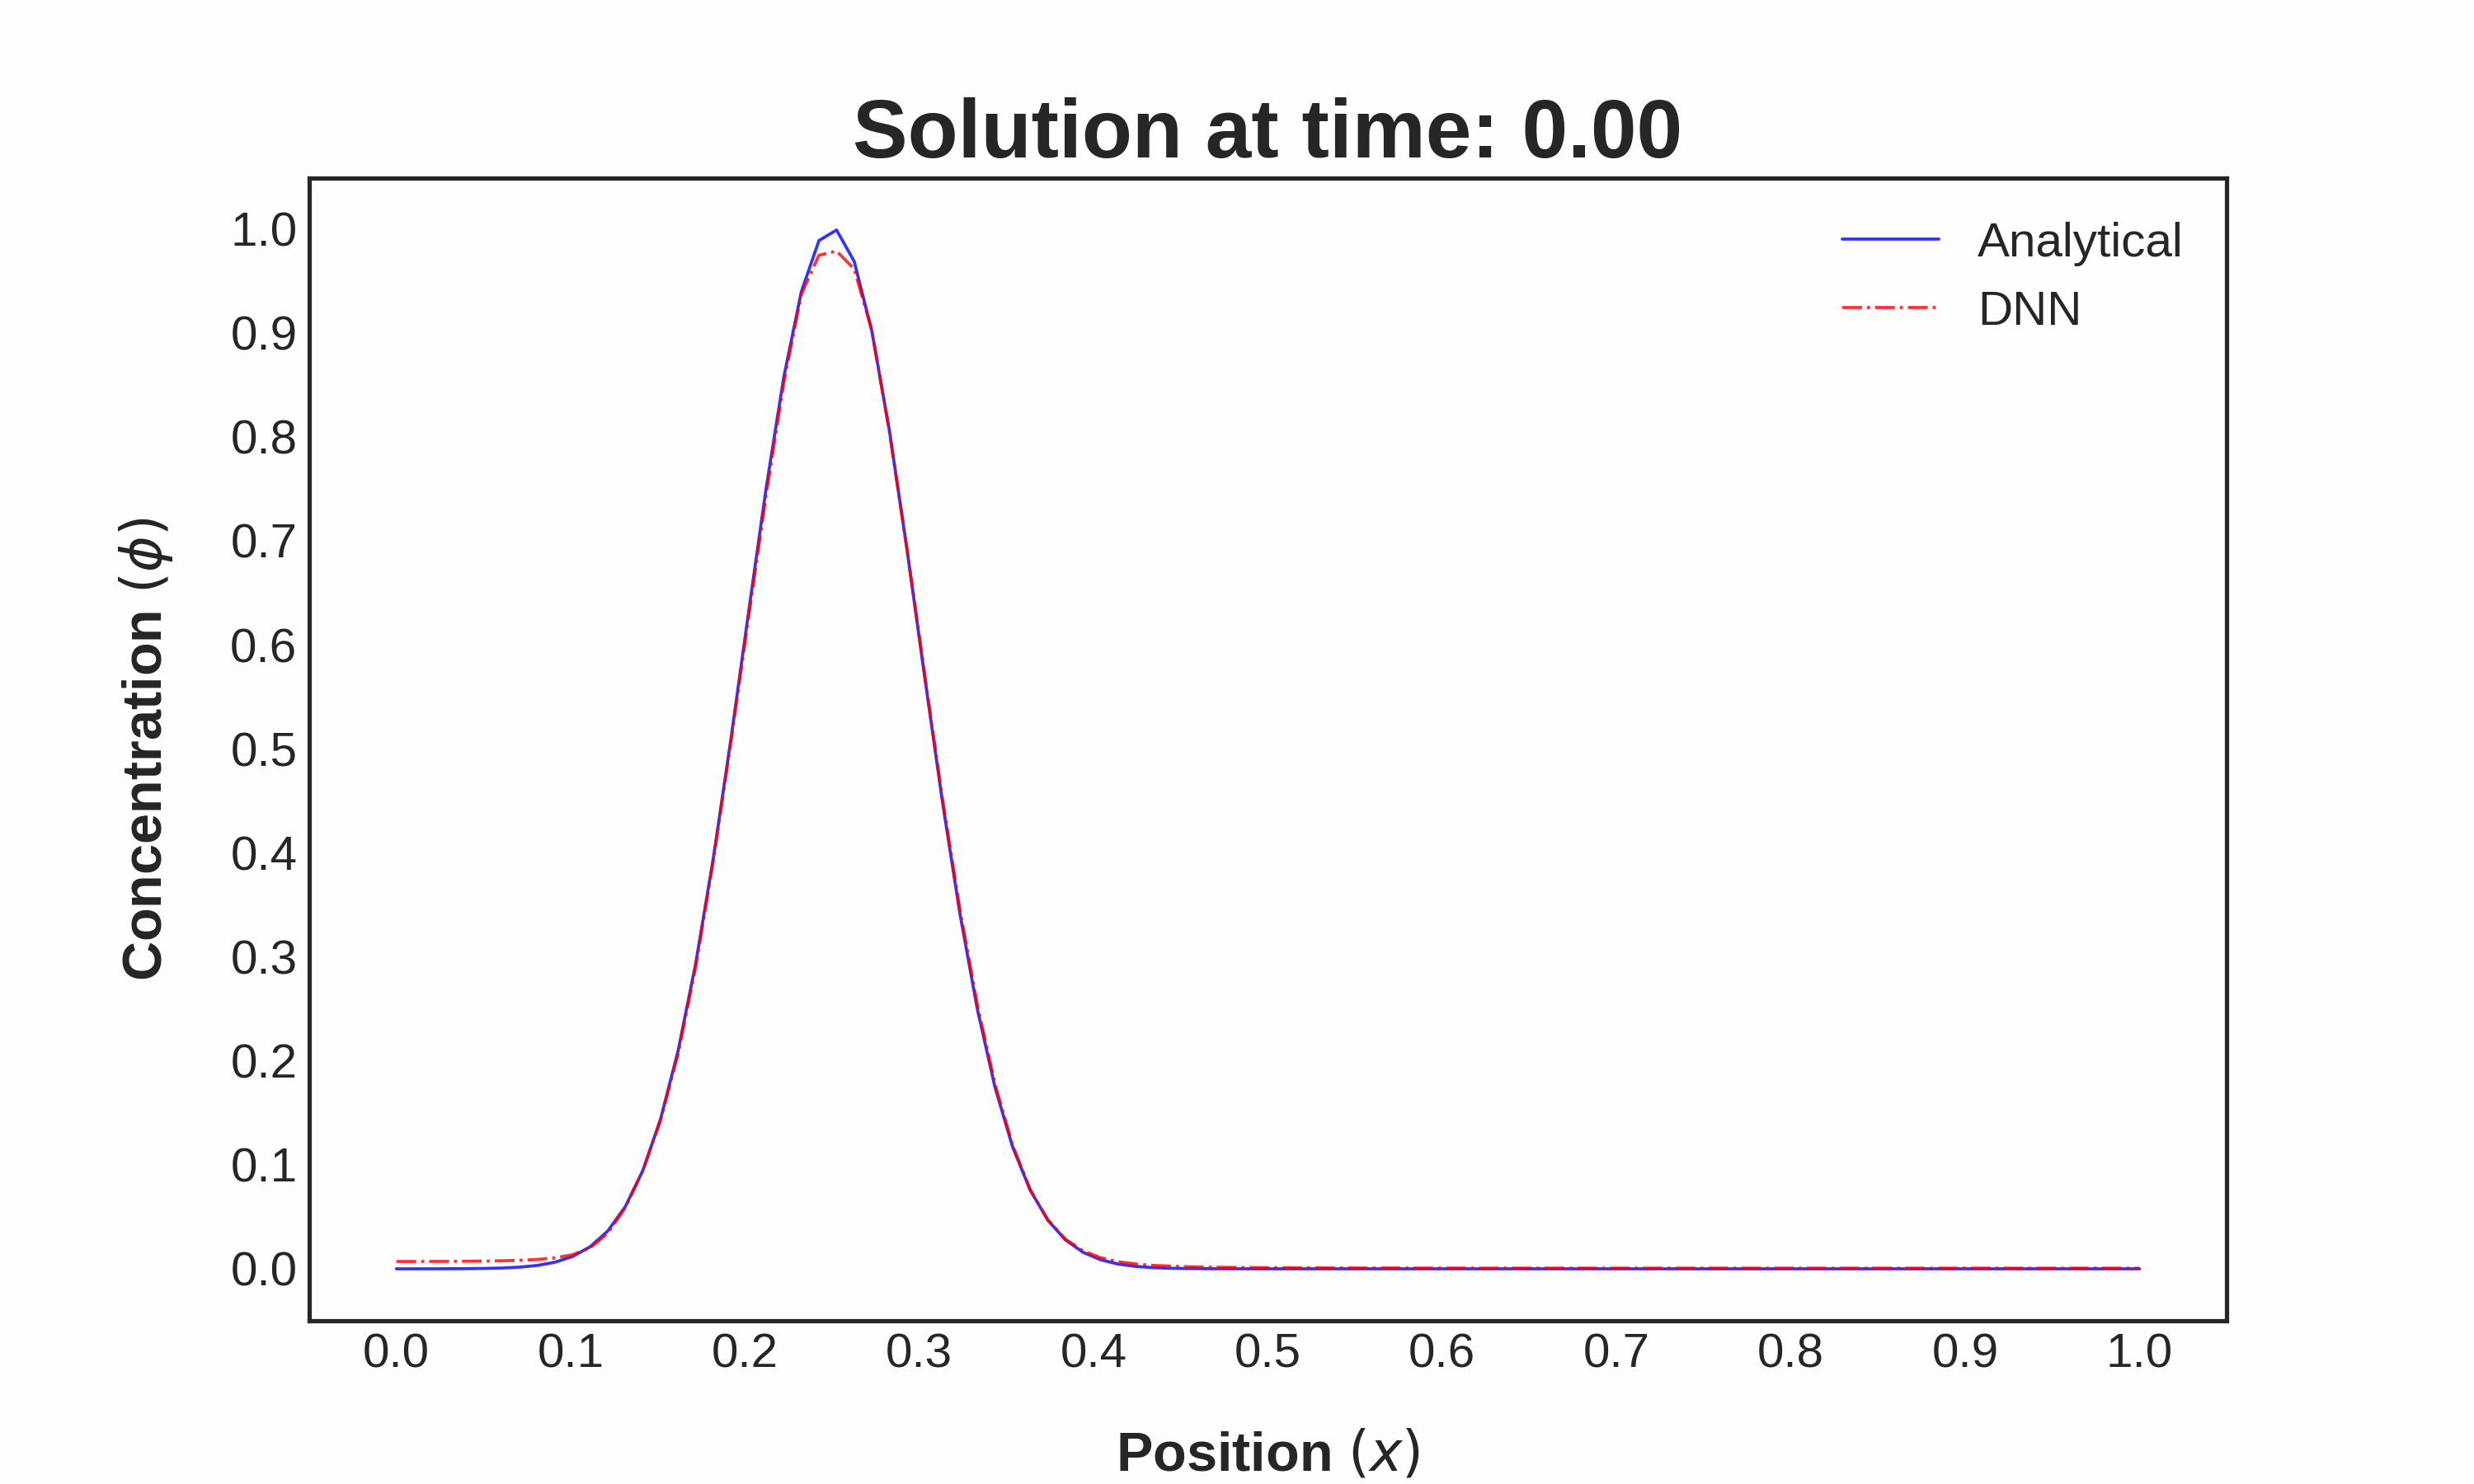

In [ ]:
from IPython.display import Image, display
display(Image(filename = my_dir+'advection_simulation.gif'))